## 准备工作

### 解压数据集

In [1]:
# # 导入zipfile模块
# import zipfile

# # 指定要解压缩的zip文件路径
# zip_file_path = '/content/drive/MyDrive/about_radar/ECG/archive.zip'

# # 指定解压缩后的目标文件夹路径
# extract_folder_path = '/content/drive/MyDrive/about_radar/ECG/data'

# # 打开zip文件
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     # 解压缩文件到指定目标文件夹
#     zip_ref.extractall(extract_folder_path)

# print("解压缩完成。")

### 加载必要的第三方库

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split # 用于分割训练样本：train and valid
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

### 加载数据：训练集和测试集

In [3]:
data_path = "./Data/"
train_df = pd.read_csv(data_path + 'mitbih_train.csv',header=None)
test_df = pd.read_csv(data_path + 'mitbih_test.csv',header=None)

In [4]:
# Assuming the target column is the last column
target_column_index = train_df.shape[1] - 1

# Get the unique values in the target column
class_labels = train_df[target_column_index].unique()

# Assign meaningful names to the class labels based on domain knowledge
class_names = {
    0: "Normal Beats",
    1: "Supraventricular Ectopy Beats",
    2: "Ventricular Ectopy Beats",
    3: "Fusion Beats",
    4: "Unclassifiable Beats"
}

# Print class labels with their assigned names
for label in class_labels:
    print(f"Class label {label}: {class_names[label]}")

Class label 0.0: Normal Beats
Class label 1.0: Supraventricular Ectopy Beats
Class label 2.0: Ventricular Ectopy Beats
Class label 3.0: Fusion Beats
Class label 4.0: Unclassifiable Beats


In [5]:
train_df[187]=train_df[187].astype(float)
equilibre = train_df[187].value_counts()
print(equilibre)

print("\n")

test_df[187]=test_df[187].astype(float)
equilibre = test_df[187].value_counts()
print(equilibre)

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


187
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64


### 可视化训练样本分布情况

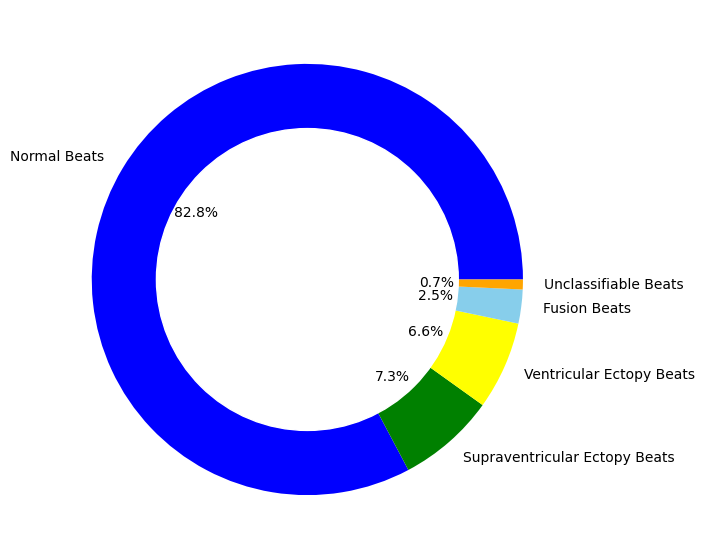

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64
5


In [6]:
plt.figure(figsize=(14,7))
my_circle=plt.Circle( (0,0), 0.7, color='white')

labels_= ['Normal Beats','Supraventricular Ectopy Beats','Ventricular Ectopy Beats','Fusion Beats','Unclassifiable Beats']
plt.pie(equilibre, labels=labels_, colors=['Blue','Green','Yellow','Skyblue','Orange'],autopct='%1.1f%%', textprops={'color': 'black'})
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

print(train_df[187].value_counts())
print(len(train_df[187].value_counts()))

In [7]:
X_train = train_df.drop(columns = [187])
y_train = train_df[187]

# Split the training data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Separate features and target variable for test dataset
X_test = test_df.drop(columns=[187])
y_test = test_df[187]

## 基于SVM模型的分类器

In [11]:
from sklearn import svm
from sklearn.metrics import accuracy_score

# Create the SVM classifier
svm_classifier = svm.SVC(kernel='rbf', random_state=42)

# Train the classifier on the normalized training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the normalized validation set
y_pred_valid = svm_classifier.predict(X_valid)

# Calculate accuracy on the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print("Validation Accuracy:", accuracy_valid)

# Make predictions on the normalized test set
y_pred_test = svm_classifier.predict(X_test)

# Calculate accuracy on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", accuracy_test)

### confusion matrix可视化

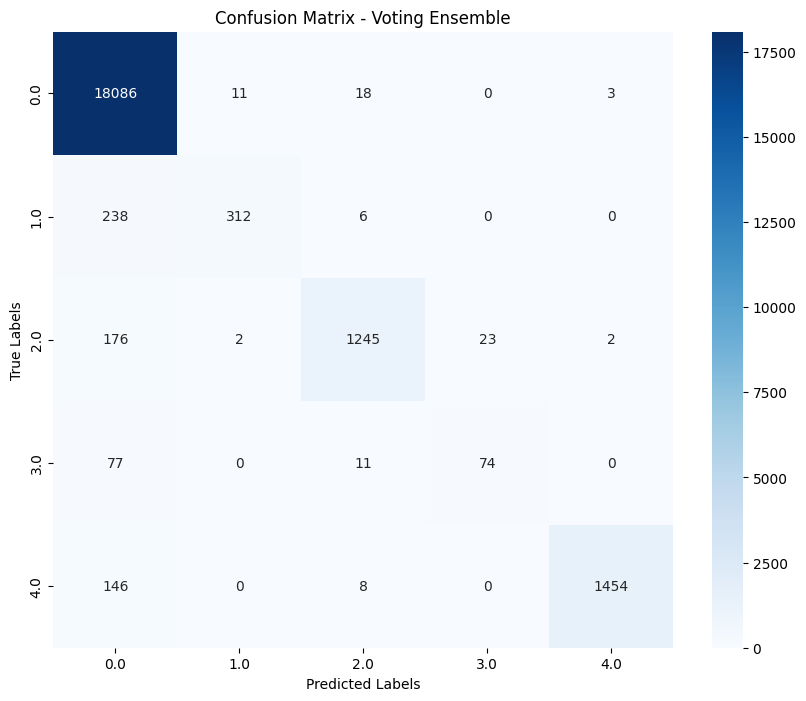

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Extract unique labels from the target variable
labels = np.unique(y_test)
# Calculate confusion matrix for the test set
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Voting Ensemble')
plt.show()

## 基于FNN模型的分类器

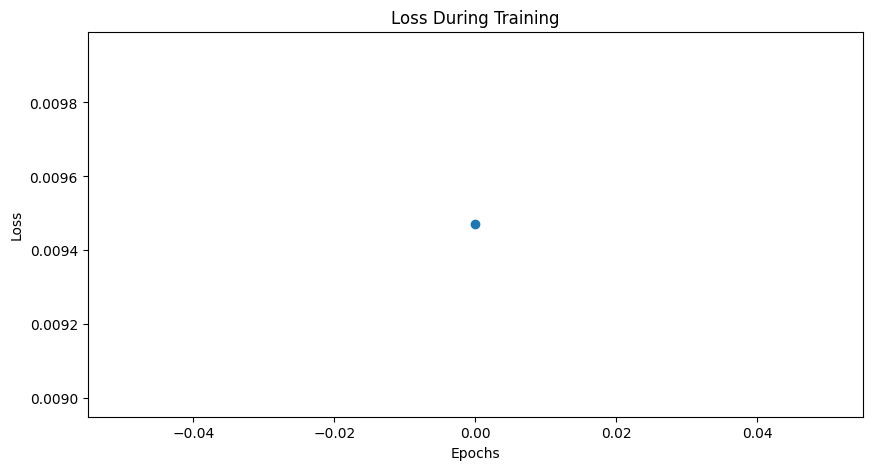

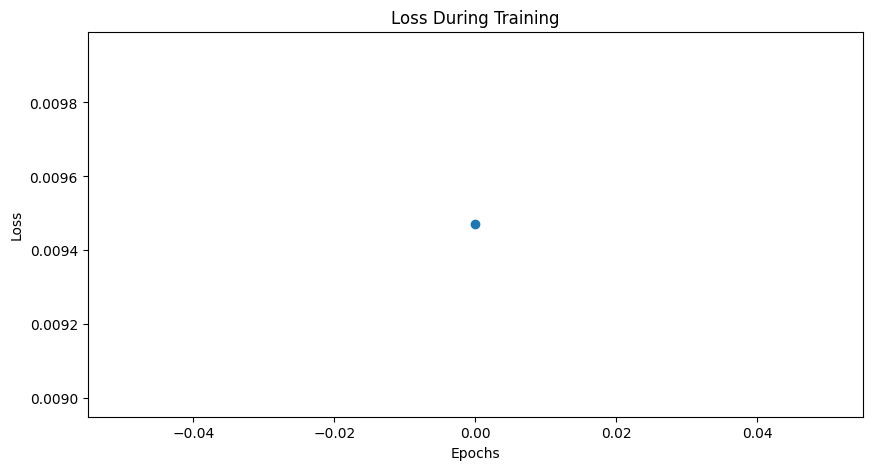

Epoch 1, Loss: 0.009470619261264801


KeyboardInterrupt: 

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from IPython.display import clear_output

import numpy as np


'''
自定义数据集，需要定义好‘__getitem__’函数
'''
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y

class FNNModel(nn.Module):
    def __init__(self):
        super(FNNModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(187, 512),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.output_layer = nn.Linear(512, 5)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output_layer(x)
        return x

# 模型训练步骤
def train_model(model, dataloader, criterion, optimizer, num_epochs=20):
    model.train()
    model.to(device)  # Move the model to the device (GPU or CPU)

    # 初始化用于绘图的损失列表
    loss_values = []

    # 设置实时更新图的基础配置
    plt.figure(figsize=(10, 5))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss During Training')

    for epoch in range(num_epochs):
        for data, labels in dataloader:
            if device.type == 'cuda':
                data, labels = data.to(device), labels.to(device)  # Move data and labels to the device
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # 记录当前epoch的损失
        loss_values.append(loss.item())

        # 动态更新图表
        clear_output(wait=True)
        plt.plot(loss_values, label='Training Loss', marker='o')
        # plt.legend()
        display(plt.gcf())
        plt.pause(0.01)  # 暂停一点时间以便更新图表

        print(f'Epoch {epoch+1}, Loss: {loss.item()}')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# 构造数据集
data, labels = X_train, y_train
data = np.array(data)
print(data.shape)

# 数据转换成tensor格式
data = torch.tensor(data, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

# 制作测试数据集
dataset = CustomDataset(data, labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# 创建模型
model = FNNModel()

# 打印模型结构
# print(model)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train your model
train_model(model, dataloader, criterion, optimizer, num_epochs=20)

### confusion matrix可视化

C:\Users\Charles\AppData\Local\Temp\ipykernel_9480\939948224.py:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels = torch.tensor(labels, dtype=torch.long)


Test Accuracy: 0.9801297277544309


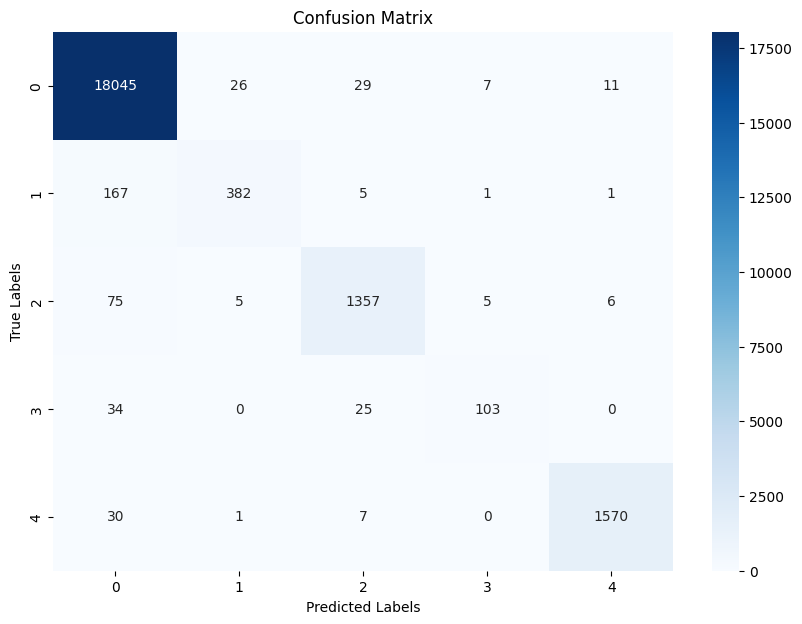

In [ ]:
def get_all_preds(model, dataloader):
    model.eval()
    all_preds = []
    true_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return true_labels, all_preds


# 加载测试数据
data, labels = X_test, y_test
data = np.array(data)
# print(data.shape)

# 数据转换成tensor格式
data = torch.tensor(data, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

# 制作测试数据集
dataset = CustomDataset(data, labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# 模型推理
true_labels, predictions = get_all_preds(model, dataloader)

# 计算测试集准确度
accuracy_test = accuracy_score(true_labels, predictions)
print("Test Accuracy:", accuracy_test)

# CM矩阵
cm = confusion_matrix(true_labels, predictions)

# 可视化
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## 基于CNN模型的分类器

### 定义CNN模型

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the CNN model using PyTorch
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            # Convolutional layer
            nn.ReLU(),
        )
        
        self.fc1 = nn.Linear(5984, 256)
        # Fully connected layer
        
        self.layer12 = nn.Sequential(
            # Activation function
            nn.BatchNorm1d(256),
            nn.ReLU(),
            # Batch normalization
            nn.MaxPool1d(kernel_size=2),
            # Max pooling
            nn.Dropout(0.5)
            # Dropout
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, padding=1),
            # Second convolutional layer
            nn.ReLU(),
        )

        self.fc2 = nn.Linear(64 * 128, 256)
        
        self.layer21 = nn.Sequential(
            nn.BatchNorm1d(256),
            nn.ReLU(),
            # Batch normalization
            nn.MaxPool1d(kernel_size=2),
            # Max pooling
            nn.Dropout(0.1)
            # Dropout
        )
                
        # Second fully connected layer

    def forward(self, x):
        x = self.layer1(x)     
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.layer12(x)
        x = x.reshape([x.shape[0],1,x.shape[1]])
        x = self.layer2(x)        
        x = x.view(x.size(0), -1)
        x = self.fc2(x)
        x = self.layer21(x)        
        return x

# Create the CNN model
cnn_model = CNNModel()

# Define the optimizer and loss function
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
        

### 训练CNN模型

In [13]:
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

'''
定义模型训练过程
'''
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0
        
        total_samples = 0
        # Progress bar
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')


        # Iterate over data.
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            # Backward + optimize
            loss.backward()
            optimizer.step()

            # Statistics
            batch_loss = loss.item() * inputs.size(0)
            running_loss += batch_loss
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{batch_loss / inputs.size(0):.4f}',
                'Acc': f'{(torch.sum(preds == labels.data).double() / inputs.size(0)).item():.4f}'
            })
            progress_bar.update()  # 确保进度条更新

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()  # Set model to evaluate mode
        val_loss = 0.0
        val_corrects = 0

        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs} Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')



# 构造数据集
X_train_tmp = np.array(X_train)
# print(X_train_tmp.shape[0], X_train_tmp.shape[1])

X_train_tmp = X_train_tmp.reshape([X_train_tmp.shape[0], 1, X_train_tmp.shape[1]])
data, labels = np.array(X_train_tmp), y_train

# 数据转换成tensor格式
data = torch.tensor(data, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

# 制作测试数据集
train_dataset = CustomDataset(data, labels)

# 构造数据集
X_test_tmp = np.array(X_test)
X_test_tmp = X_test_tmp.reshape([X_test_tmp.shape[0], 1, X_test_tmp.shape[1]])
data, labels = np.array(X_test_tmp), y_test

# 数据转换成tensor格式
data = torch.tensor(data, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

# 制作测试数据集
val_dataset = CustomDataset(data, labels)

# Assuming train_dataset and val_dataset are already defined
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_model = cnn_model.to(device)
train_model(cnn_model, train_loader, val_loader, criterion, optimizer, num_epochs=25)

C:\Users\Charles\AppData\Local\Temp\ipykernel_6984\3755445338.py:88: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels = torch.tensor(labels, dtype=torch.long)
C:\Users\Charles\AppData\Local\Temp\ipykernel_6984\3755445338.py:100: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels = torch.tensor(labels, dtype=torch.long)
Epoch 1/25: 100%|█████████▉| 4377/4378 [00:29<00:00, 148.33batch/s, Loss=1.0314, Acc=0.8182]

Epoch 1/25 Train Loss: 0.7571 Acc: 0.8549
Epoch 1/25 Validation Loss: 0.3366 Acc: 0.9260



Epoch 1/25: 100%|██████████| 4378/4378 [00:32<00:00, 135.54batch/s, Loss=1.0314, Acc=0.8182]












































































































































































































































































































































































































































































































































































































































































































































































































































































































































Epoch 2/25 Train Loss: 0.6931 Acc: 0.8655
Epoch 2/25 Validation Loss: 0.3390 Acc: 0.9180


Epoch 3/25:   3%|▎         | 117/4378 [00:00<00:29, 146.63batch/s, Loss=0.6808, Acc=0.8750]

KeyboardInterrupt: 